In [16]:
import os
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
from dotenv import load_dotenv

In [17]:
# 指定 STFT 參數
load_dotenv()
sample_rate = int(os.getenv('sample_rate'))
n_mels = int(os.getenv('n_mels'))
# n_fft = int(os.getenv('n_fft'))

print(f'Sample rate: {sample_rate}, n_mels: {n_mels}')

Sample rate: 44100, n_mels: 256


In [18]:
def load_segmented_files(directory):
    wav_files = []
    for dir in os.listdir(directory):
        if dir.endswith('_anomaly'):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            filename = f'{dir}_{file}'
            wav_files.append((y, filename))

    return wav_files

In [19]:
# 讀取分割後的音訊片段
normal_segments = load_segmented_files('audio')

In [20]:
from conver_mel_spectrogram import compute_mel_spectrogram
def convert_to_mel_spectrogram(audio, sr):
    mel_spectrogram, hop_length = compute_mel_spectrogram(audio, sr)
    return mel_spectrogram

In [21]:
# 打亂 mel_spectrograms_normal 列表
np.random.shuffle(normal_segments)
print(f'Number of normal segments: {len(normal_segments)}')
audio_data, filename = normal_segments[0]
print(f'Audio data shape: {audio_data.shape}, filename: {filename}')
mel_spectrogram_db, hop_length = compute_mel_spectrogram(audio_data, sample_rate)
print(f"Mel spectrogram shape: {mel_spectrogram_db.shape}")
print(mel_spectrogram_db, hop_length)


Number of normal segments: 2832
Audio data shape: (220500,), filename: soundcam_dataset_normal-34A-12-50-2_Mic028_segment_0.wav
Mel spectrogram shape: (128, 431)
[[-17.017294  -18.113771  -25.04017   ... -11.131861  -12.196087
  -12.271839 ]
 [-17.104877  -18.018152  -21.727766  ... -13.032061  -14.481297
  -12.1552925]
 [-20.305714  -15.581696  -18.267872  ... -19.878048  -20.33273
  -14.669205 ]
 ...
 [-70.9269    -69.84273   -72.41846   ... -69.095505  -69.83153
  -67.231384 ]
 [-78.50651   -78.23857   -80.        ... -78.191315  -78.04848
  -69.39397  ]
 [-80.        -80.        -80.        ... -80.        -80.
  -70.446304 ]] 512


In [22]:
mel_spectrograms_normal = [convert_to_mel_spectrogram(audio[0], sample_rate) for audio in tqdm(normal_segments)]

100%|██████████| 2832/2832 [00:24<00:00, 114.41it/s]


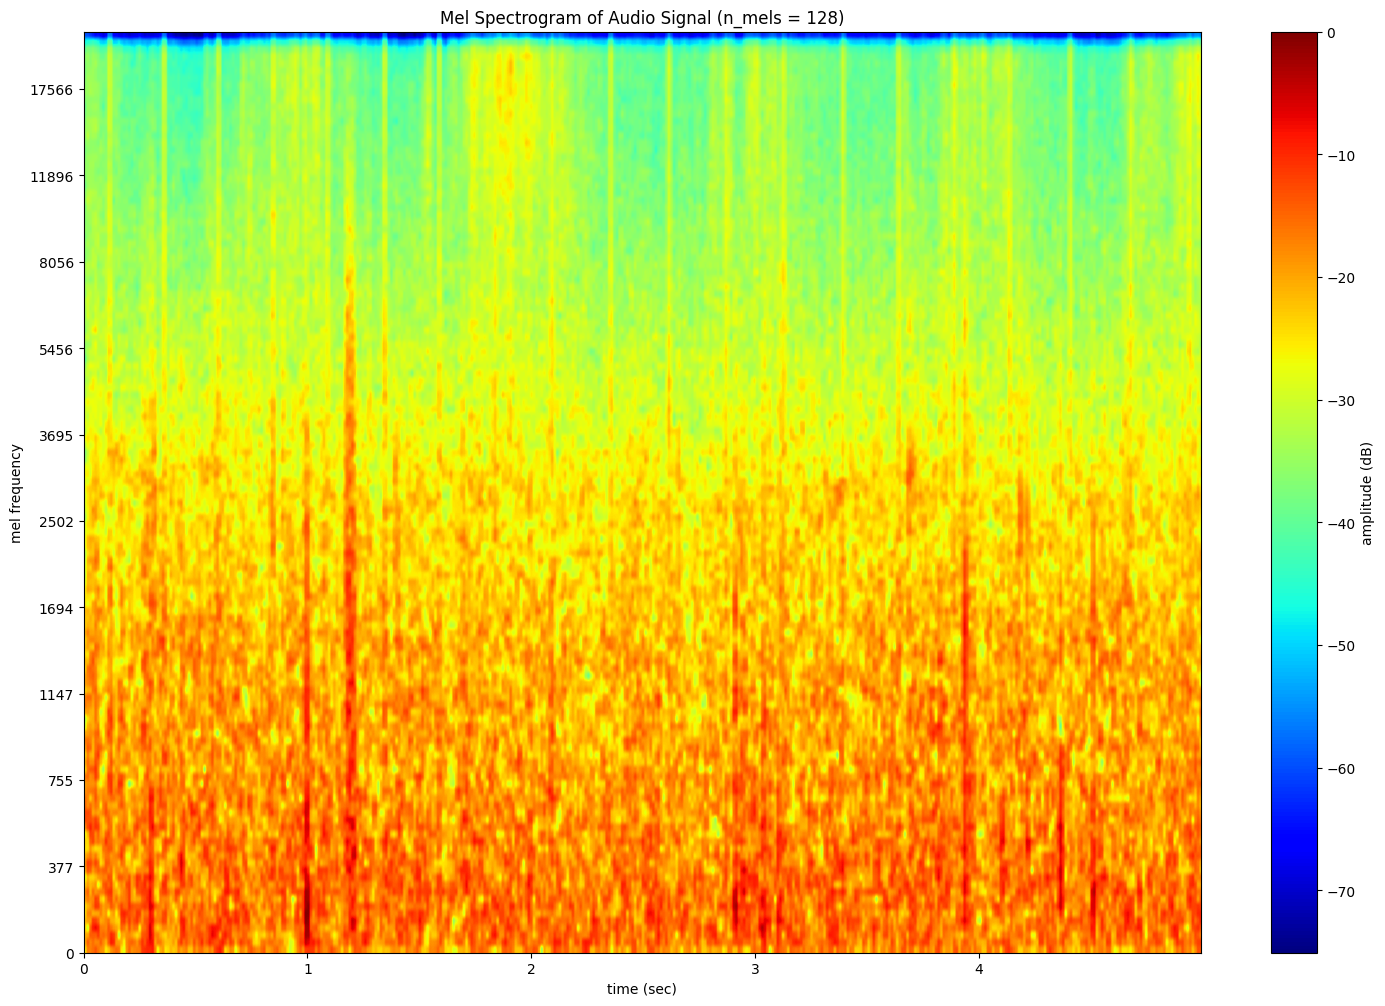

Mel spectrogram: filename: soundcam_dataset_normal-34A-12-10-2_Mic017_segment_5.wav


In [23]:
from conver_mel_spectrogram import plot_mel_spectrogram
plot_mel_spectrogram(mel_spectrograms_normal[10], hop_length=hop_length, sample_rate=sample_rate, save_file=False, camp='jet') 
print(f"Mel spectrogram: filename: {normal_segments[10][1]}")

# Spilt Dataset to training and testing

In [24]:
from sklearn.model_selection import train_test_split

# 將梅爾頻譜圖轉換為numpy數組
mel_spectrograms_array = np.array(mel_spectrograms_normal)

# 對數據進行切分
train_data, test_data = train_test_split(mel_spectrograms_array, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (1812, 128, 431)
驗證集數據形狀: (453, 128, 431)
測試集數據形狀: (567, 128, 431)


# 調整數據的形狀

In [25]:
# 調整數據的形狀
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
val_data = val_data.reshape(val_data.shape[0], val_data.shape[1], val_data.shape[2], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

# 數據歸一化到 [0, 1]
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())
val_data = (val_data - val_data.min()) / (val_data.max() - val_data.min())
test_data = (test_data - test_data.min()) / (test_data.max() - test_data.min())
# 打印轉換後的數據形狀
print("訓練集數據形狀:", train_data.shape)
print("驗證集數據形狀:", val_data.shape)
print("測試集數據形狀:", test_data.shape)

訓練集數據形狀: (1812, 128, 431, 1)
驗證集數據形狀: (453, 128, 431, 1)
測試集數據形狀: (567, 128, 431, 1)


# 創建 CNN Autoencoder 模型

In [42]:
from keras.layers import Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Reshape, \
    BatchNormalization
from tensorflow.keras.regularizers import l2


def create_cnn_autoencoder(input_shape):
    input_img = Input(shape=input_shape)
    input_height = input_shape[0]
    input_width = input_shape[1]
    
    # Encoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)
    
    # Flatten and Dense layers at bottleneck
    x = Flatten()(encoded)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(encoded.shape[1] * encoded.shape[2] * encoded.shape[3], activation='relu')(x)
    x = Reshape((encoded.shape[1], encoded.shape[2], encoded.shape[3]))(x)
    
    # Decoder
    x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu',padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(x)
    x = UpSampling2D((2, 2))(x)
    
    # Ensure the output has the same size as input
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    decoded = Lambda(lambda x: x[:, :input_height, :input_width, :])(decoded)
    
    autoencoder = Model(input_img, decoded)
    return autoencoder



# 初始化模型

In [43]:
# 指定輸入形狀
input_shape = np.shape(train_data)[1:]

# 創建 CNN Autoencoder 模型
autoencoder = create_cnn_autoencoder(input_shape)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 conv2d_27 (Conv2D)          (None, 128, 431, 256)     2560      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 64, 216, 256)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 64, 216, 128)      295040    
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 32, 108, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 32, 108, 64)       7379

In [44]:
def plot_model(autoencoder):
    from tensorflow.keras.utils import plot_model
    plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)
    
plot_model(autoencoder)

In [45]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
# 設定初始學習率
initial_learning_rate = 0.0001

# 創建 Adam 優化器並指定學習率
optimizer = Adam(learning_rate=initial_learning_rate)

def weighted_loss_function(y_true, y_pred):
    # 創建與 y_true 相同形狀的權重矩陣
    weights = tf.ones_like(y_true)

    # 假設我們想加權 Mel 頻譜圖中高頻段的前半部分
    freq_cutoff = weights.shape[1] // 2
    high_freq_weights = 1.2

    # 創建權重矩陣
    freq_weights = tf.concat([tf.fill([freq_cutoff, 1], high_freq_weights), tf.ones([weights.shape[1] - freq_cutoff, 1])], axis=0)
    freq_weights = tf.reshape(freq_weights, [1, weights.shape[1], 1, 1])

    # 對 y_pred 進行平滑，防止極端值
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

    # 加權交叉熵損失
    weighted_loss = -freq_weights * (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

    return tf.reduce_mean(weighted_loss)

def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    mae_loss = tf.keras.losses.mean_absolute_error(y_true, y_pred)
    return mse_loss + mae_loss

def mixed_loss_function(y_true, y_pred):

    # 高頻加權的損失
    weights = tf.ones_like(y_true)
    freq_cutoff = weights.shape[1] // 2
    high_freq_weights = 1.2
    freq_weights = tf.concat([tf.fill([freq_cutoff, 1], high_freq_weights), tf.ones([weights.shape[1] - freq_cutoff, 1])], axis=0)
    freq_weights = tf.reshape(freq_weights, [1, weights.shape[1], 1, 1])

    y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
    weighted_loss = -freq_weights * (y_true * tf.math.log(y_pred) + (1 - y_true) * tf.math.log(1 - y_pred))

    weighted_loss = tf.reduce_mean(weighted_loss)

    # 混合兩種損失函數，權重比例可以調整
    return 0.8 * combined_loss(y_true, y_pred) + 0.2 * weighted_loss

# 編譯模型
autoencoder.compile(optimizer=optimizer, loss=mixed_loss_function)

# 訓練模型

In [46]:

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)
# 定義學習率調整策略
history = autoencoder.fit(train_data, train_data,
                epochs=200,
                batch_size=16,
                shuffle=True,
                validation_data=(test_data, test_data),
                callbacks=[early_stopping],
                verbose=2)

Epoch 1/200
114/114 - 23s - loss: 0.7670 - val_loss: 0.7041 - 23s/epoch - 203ms/step
Epoch 2/200
114/114 - 17s - loss: 0.5166 - val_loss: 0.5355 - 17s/epoch - 148ms/step
Epoch 3/200
114/114 - 17s - loss: 0.4095 - val_loss: 0.4013 - 17s/epoch - 150ms/step
Epoch 4/200
114/114 - 17s - loss: 0.3492 - val_loss: 0.3486 - 17s/epoch - 153ms/step
Epoch 5/200
114/114 - 17s - loss: 0.3149 - val_loss: 0.3152 - 17s/epoch - 151ms/step
Epoch 6/200
114/114 - 17s - loss: 0.2900 - val_loss: 0.2826 - 17s/epoch - 151ms/step
Epoch 7/200
114/114 - 17s - loss: 0.2758 - val_loss: 0.2760 - 17s/epoch - 151ms/step
Epoch 8/200
114/114 - 17s - loss: 0.2605 - val_loss: 0.2537 - 17s/epoch - 151ms/step
Epoch 9/200
114/114 - 17s - loss: 0.2520 - val_loss: 0.2446 - 17s/epoch - 151ms/step
Epoch 10/200
114/114 - 17s - loss: 0.2422 - val_loss: 0.2415 - 17s/epoch - 151ms/step
Epoch 11/200
114/114 - 17s - loss: 0.2360 - val_loss: 0.2311 - 17s/epoch - 151ms/step
Epoch 12/200
114/114 - 17s - loss: 0.2291 - val_loss: 0.2289 - 

# 評估模型

In [47]:
test_loss = autoencoder.evaluate(val_data, val_data)
print("Test loss:", test_loss)

15/15 [==============================] - 3s 104ms/step - loss: 0.1571
Test loss: 0.15713846683502197


# 繪製訓練過程

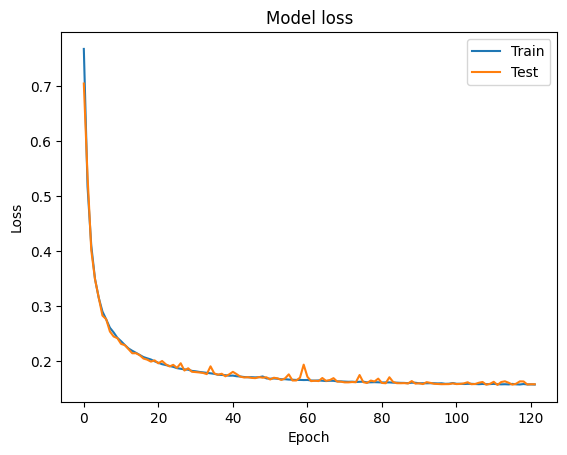

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig('model_loss.png')
plt.show()

# 儲存模型

In [49]:
autoencoder.save('autoencoder_10_11.h5')

# 使用測試集數據進行預測

In [50]:
def calculate_reconstruction_error(original, reconstructed):
    # 如果只有單個樣本，確保數據是 4D
    if len(original.shape) == 3:
        original = np.expand_dims(original, axis=0)
        reconstructed = np.expand_dims(reconstructed, axis=0)
    return np.mean(np.square(original - reconstructed), axis=(1, 2, 3))

In [51]:
# 計算每個樣本的重建損失
reconstructed_data = autoencoder.predict(train_data)
reconstruction_errors = calculate_reconstruction_error(train_data, reconstructed_data)

# 設定一個閾值來判斷異常
threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
print(f'Threshold: {threshold}')

57/57 [==============================] - 6s 99ms/step
Threshold: 0.0031631955644115806


In [52]:
# 測試數據集上的重建
reconstructed_test_data = autoencoder.predict(test_data)

# 計算測試數據集上的重建誤差
test_reconstruction_errors = calculate_reconstruction_error(test_data, reconstructed_test_data)

# 判斷異常樣本
anomalies = test_reconstruction_errors > threshold
normal = test_reconstruction_errors <= threshold
print(f"Number of anomalies detected: {np.sum(anomalies)}")

# 可視化一些異常樣本
anomalous_data = test_data[anomalies]
anomalous_reconstructed_data = reconstructed_test_data[anomalies]

18/18 [==============================] - 3s 152ms/step
Number of anomalies detected: 16


In [53]:
# 測試單個樣本的重建誤差
error = calculate_reconstruction_error(test_data[0], reconstructed_test_data[0])[0]

In [54]:
def plot_comparison(input_mel_spectrogram, output_mel_spectrogram, input_title, output_title, threshold, loss, output_dir='images/reconstruct_anomaly', output_name='comparison', save_only=False):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.figure(figsize=(20, 5))
    
    # 繪製輸入梅爾頻譜圖
    plt.subplot(1, 2, 1)
    librosa.display.specshow(input_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length, cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title(input_title)
    
    # 繪製輸出梅爾頻譜圖
    plt.subplot(1, 2, 2)
    librosa.display.specshow(output_mel_spectrogram, x_axis='time', y_axis='mel', sr=sample_rate, hop_length=hop_length, cmap='jet')
    plt.colorbar(format='%+2.0f dB')
    plt.title(output_title)
    # plot mse if mse in red if mse > mse_threshold
    plt.text(0, 0, f'loss: {loss}', fontsize=12, color='red' if loss > threshold else 'black', backgroundcolor='white')
    
    plt.tight_layout()
    if save_only:
        plt.savefig(f'{output_dir}/{output_name}.png')
        plt.close()
    else:
        plt.show()

In [55]:
anomalies_index = np.where(anomalies)[0]
for i in tqdm(anomalies_index):
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_test_data[i].reshape(reconstructed_test_data[i].shape[0], reconstructed_test_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', 
                    threshold=threshold, loss=test_reconstruction_errors[i],
                    output_dir='images/reconstruct_anomaly',
                    output_name=f'anomaly_{i}', save_only=True)

100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


In [56]:
normal_index = np.where(normal)[0]
for i in tqdm(normal_index):
    loss = calculate_reconstruction_error(test_data[i], reconstructed_test_data[i])
    plot_comparison(test_data[i].reshape(test_data[i].shape[0], test_data[i].shape[1]),
                    reconstructed_test_data[i].reshape(reconstructed_test_data[i].shape[0], reconstructed_test_data[i].shape[1]),
                    'Original Mel Spectrogram', 'Reconstructed Mel Spectrogram', threshold=threshold, loss=loss, 
                    output_dir='images/reconstruct_normal',
                    output_name=f'normal_{i}', save_only=True)

 36%|███▌      | 196/551 [01:06<01:59,  2.97it/s]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000227540C7DC0> (for post_execute):


KeyboardInterrupt: 

計算重建失敗的數量

In [57]:
print(f'Failed reconstruction count is {len(anomalies_index)}, total test data is {len(test_data)}')
print(f'Failed reconstruction rate is {len(anomalies_index) / len(test_data) * 100}%')
print(f'Success reconstruction rate is {100 - len(anomalies_index) / len(test_data) * 100}%')


Failed reconstruction count is 16, total test data is 567
Failed reconstruction rate is 2.821869488536155%
Success reconstruction rate is 97.17813051146385%


Failed reconstruction count is 16, total test data is 567
Failed reconstruction rate is 2.821869488536155%


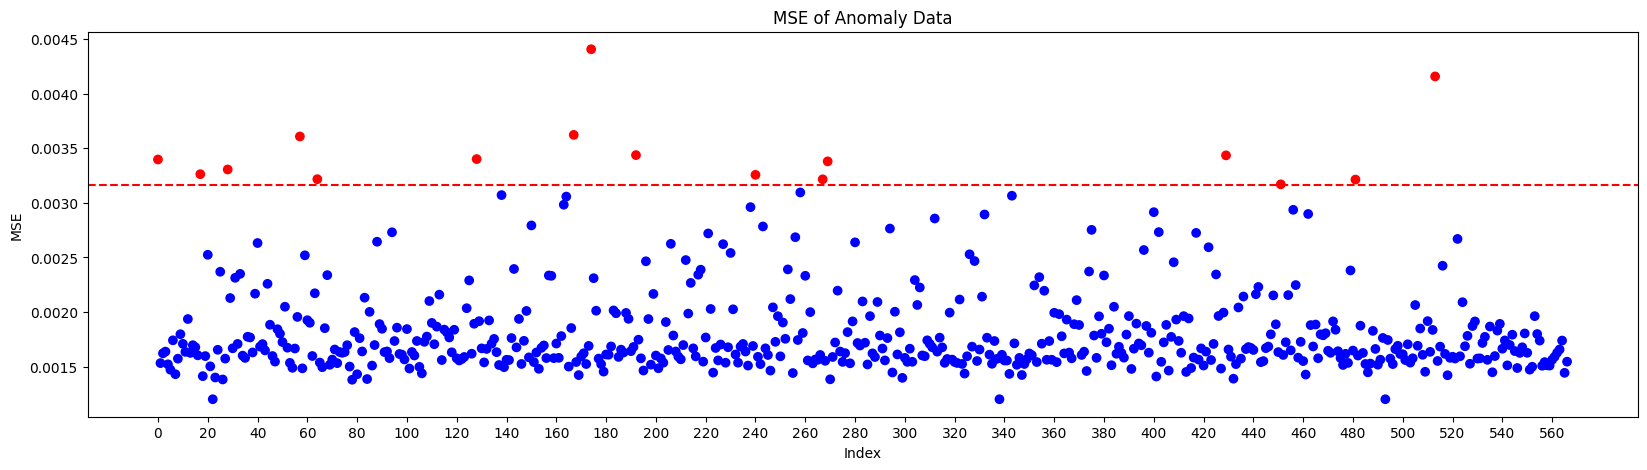

In [58]:
# plot anomalies scatter plot
plt.figure(figsize=(20, 5))
# use red color if mse > mse_threshold
plt.scatter(range(0, len(test_reconstruction_errors)), test_reconstruction_errors, 
            color=['red' if loss > threshold else 'blue' for loss in test_reconstruction_errors])
plt.axhline(y=threshold, color='r', linestyle='--')
plt.title('MSE of Anomaly Data')
plt.xlabel('Index')
plt.xticks(range(0, len(test_reconstruction_errors), 20))
plt.ylabel('MSE')
plt.savefig('images/mse_anomaly.png')
print(f'Failed reconstruction count is {len(anomalies_index)}, total test data is {len(test_data)}')
print(f'Failed reconstruction rate is {len(anomalies_index) / len(test_data) * 100}%')